# Animal-AI Environment tutorial

This tutorial is a step-by-step presentation of the new version of the Animal-AI library. The new Animal-AI environment is quite similar to the version used for the competition, however the `animalai` and `animalai_train` APIs have been dramatically improved, reflecting the great improvements made by [Unity ml-agents](https://github.com/Unity-Technologies/ml-agents).

In this notebook, **we present the environment and discuss how to design both your training and testing setups**. In the second notebook (training) we'll show you how to train an agent to solve a task it has never seen before.

## Introducing animal cognition to the AI world

Our goal is to provide a tool for researchers to go beyond classical RL environments, allowing you to develop agents that possess cogintive skills similar to animal's. The main idea is to be able to test and/or train your agents on **experiments taken or inspired from real life animal experiments**. This repository holds 900 such experiments which cover a dozen cognitive skills. You can find more details on the test-bed on [our website](http://animalaiolympics.com/AAI/testbed)

The environment is a simple arena with an agent that can only move left, right, forward and backward, aiming to collect positive reward and avoid negative ones. It can also hold [several objects](https://github.com/beyretb/AnimalAI-Olympics/blob/master/documentation/definitionsOfObjects.md) which can be used to set up experiments. You can really put yourself in the shoes of an animal cognition scientist building experiments with whatever you can find in a lab.

From the agent's perspective, a classical experiment called a Y-maze looks like this(the agent must explore a simple Y-shaped maze to find a reward, often food):

<img src="notebook_data/y_maze.png" width="40%">

The agent is on an elevated platform (blue), needs to move towards the reward (green ball) and avoid going to the right in which case the agent would be stuck (the platform is too high for the agent to climb back on).

From an RL perspective this might seem like a trivial problem to solve! In a classical RL setup where you train and test on the same problem it is indeed simple. However, when tested on a similar task, an animal would encounter this problem for the first time. And this is what we encourage you to do as well: **create your own training curriculum, and use our experiments as a test set your agent has never seen before**. We believe this is needed to truly test an agent's capacity to acquire cognitive skills.


But enough chit-chat, let's dive right in with an example!

In [1]:
from IPython.display import HTML
from animalai.envs.arena_config import ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException


## Can your agent self control? - Part I

Self control is hard, we've all been there (looking at you chocolate bar). But don't worry, this is something a lot of species struggle with. In [The evolution of self-control](https://www.pnas.org/content/111/20/E2140) MacLean et al. tested this ability in **36 different species**! In a very simple experiment, animals are offered food they can reach easily by reaching out to it. But then, they're shown the same food behind a transparent wall, they need to go around the wall to grab the food. They can see the food just as well, but they need to refrain from reaching out like before.

Below are videos of such animals, as well as two participants' submissions to our compeition, exhibiting similar behaviors (remember, these agents never encoutered this task during training):                                                                                             

In [ ]:
HTML('<div><div><video width="24%" playsinline="" autoplay="" muted="" loop=""><source src="notebook_data/animal-cyl-pass.mp4" type="video/mp4"></video><video width="24%" " playsinline="" autoplay="" muted="" loop=""><source src="notebook_data/agent-cyl-pass.mp4" type="video/mp4"></video><video width="24%" playsinline="" autoplay="" muted="" loop=""><source src="notebook_data/animal-cyl-fail.mp4" type="video/mp4"></video><video width="24%" playsinline="" autoplay="" muted="" loop=""><source src="notebook_data/agent-cyl-fail.mp4" type="video/mp4"></video></div>')

In the following sections we'll design a training curriculum which does not include the exact "reward in a transparent cylinder" task, but which we can use to train an agent that can solve this same task. In the training tutorial, we'll train such an agent using this curriculum.


## Let's get started: experiments design

First things first, as rigorous researchers, we want to design a good training environment. To do so, we provide a [list of items](https://github.com/beyretb/AnimalAI-Olympics/blob/master/examples/environment_tutorial.ipynb) you can include in your arena, you can have a look at the details later, this section highlights the basics.

To begin with let's train an agent to collect food right in front of it, as simple as that! To do so, you'll need to design a `yaml` file which describes the experiment setup. It contains:

- experiment parameters (maximum steps, steps at which the light is turned on/off)
- a list of objects
- their specifications (positions, rotations, sizes, colors) which are randomized if not provided

Below is the simplest example possible:

In [ ]:
with open('configurations/curriculum/0.yml') as f:
    print(f.read())

This file contains the configuration of one arena (`!Arena`), with only the agent on the ground (`y=0`) in the center (`x=20`,`z=20`) and a `GoodGoal` (green sphere) of size 1 in front of it (`x=20`,`z=22`). Pretty simple right!

One _little trick_ we used here: one environment can contain several arenas during training, each with its own configuration. This allows your training algorithm to collect more observations at once. You can just place the configurations one after the others like this:
```
!ArenaConfig
arenas:
  0: !Arena
    ......
  1: !Arena
    ......
  2: !Arena
    ......
```
But if you want all the arenas in the environment to have the same configuration then do as we did above: define one configuration only with key `-1`

You can now use this to load an environment and play yourself (`load_config_and_play.py` does that for you). Make sure you have followed the [installation guide](https://github.com/beyretb/AnimalAI-Olympics#requirements) and then create an `AnimalAIEnvironment` in play mode:

In [ ]:
try:
    environment = AnimalAIEnvironment(
            file_name='env/AnimalAI',
            base_port=5005,
            arenas_configurations=ArenaConfig('configurations/curriculum/0.yml'),
            play=True,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

Press **C** to change the viewpoint (bird's eye, first person, third person), and move with **W,A,S,D** or the **arrows** on your keyboard. Once you're done, let's close this environment:

In [ ]:
if environment:
    environment.close() # takes a few seconds

## Creating a curriculum

Such a training set is not going to get us very far... The food is right before the agent, it won't even learn any sort of exploration - not even turning around to see if the food is behing it. [Curriculum learning](https://lilianweng.github.io/lil-log/2020/01/29/curriculum-for-reinforcement-learning.html) uses a set of training configurations of increasing difficulty in order to learn a complex task. Think "stand up before you walk, walk before you run" type of learning.

To solve our problem, we might want to have the following consecutive learning steps:

1. food right in front of the agent (example above)
2. food in front of the agent, but further away
3. food at the same distance as 2, but randomize the agent's rotation (might be behind the agent)
4. agent and food randomly placed on a fixed z-axis, and a small transparent wall in between the two
5. same as 4 with increasingly bigger walls

To design a curriculum, we need to place all the yaml files in a folder along with a json configuration file which contains the details of when to switch from one level to the next. The above curriculum can be found in `configurations/curriculum`.

The second configuration is just like the first but with `z: 35` for `GoodGoal`. The third one only requires randomizing the rotation; achieved by replacing `rotations: [0]` with `rotations: [-1]`, as any parameter with a value of `-1` is randomized. Otherwise you can just remove the `rotations` line altogether, and the rotation will be randomized automatically (also works with positions, sizes and colors).

Putting all of the above together, we can have a look at step 4:

In [ ]:
configuration = 'configurations/curriculum/3.yml'
with open(configuration) as f:
    print(f.read())
    
try:
    environment = AnimalAIEnvironment(
            file_name='env/AnimalAI',
            base_port=5005,
            arenas_configurations=ArenaConfig(configuration),
            play=True,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

Play a few runs with this configuration, you'll see the various items randomly appearing along a given axis. You can **press R** to reset the environment. Once you're done, close the environment:

In [ ]:
if environment:
    environment.close() # takes a few seconds

Finally, the file `AnimalAI.json` holds the parameters for the process (the name of this file **must remain AnimalAI.json**), and looks like this:

In [ ]:
with open('configurations/curriculum/AnimalAI.json') as f:
    print(f.read())

This tells you that we'll switch from one level to the next once the reward per episod is above 0.8. Easy right?

In the next notebook we'll use the above curriculum example to train an agent that can solve the tube task we saw in the videos earlier. Before that, it is worth looking at an extra feature of the environment (blackouts) as well as interacting with the environment from python rather than playing manually.

## Interacting with the environment + bonus light switch!

In this final part, we look at the API for interacting with the environment. Namely, we want to take steps, collect observations and rewards. For this part we'll load an environment which tests for a cognitive skill called **object permanence**. It tests the capacity of an agent to understand that an object still exists even if it is moved out of sight; think of a car turning a corner - we all know the car hasn't vanished from existence. This test introduces another feature of the environment: **the light switch** which allows us to switch the light in the environment on and off. Let's have a look at the experiment:

In [2]:
light_switch_conf = 'configurations/arena_configurations/light_switch.yml'

try:
    environment = AnimalAIEnvironment(
            file_name='env/AnimalAI',
            base_port=5005,
            arenas_configurations=ArenaConfig(light_switch_conf),
            play=True,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

Change the point of view by pressing **C** and then reset by pressing **R**. As you can see, the light switches off just before you can see the reward disappear, but you probably figured out where it had gone, right?

This is achieved by adding the `blackouts` parameter to your configuration file. This consists of a list of frames at which the light should switch on, off, on, off... Below we switch the light off at frame 20 and then back on at 50. You can also **provide a negative number**, e.g. `blackouts: [-20]`, to switch on/off every 20 frames.

In [3]:
if environment:
    environment.close() # takes a few seconds
    
with open(light_switch_conf) as f:
    print(f.read())

!ArenaConfig
arenas:
  0: !Arena
    pass_mark: 0
    t: 500
    blackouts: [20,50]
    items:
    - !Item
      name: GoodGoalBounce
      positions:
      - !Vector3 {x: 30, y: 0, z: 30}
      rotations: [270]
      sizes:
      - !Vector3 {x: 1, y: 1, z: 1}
    - !Item
      name: Wall
      positions:
      - !Vector3 {x: 7.5, y: 0, z: 25}
      rotations: [90]
      sizes:
      - !Vector3 {x: 1, y: 3, z: 15}
      colors:
      - !RGB {r: 153, g: 153, b: 153}
    - !Item
      name: Ramp
      positions:
        - !Vector3 {x: 10, y: 0, z: 30}
      rotations: [90]
      sizes:
        - !Vector3 {x: 1, y: 0.2, z: 1}
      colors:
        - !RGB {r: 153, g: 153, b: 153}
    - !Item
      name: Agent
      positions:
      - !Vector3 {x: 20, y: 0, z: 5}
      rotations: [0]


To finish this tutorial on the environment and associated API, we look at how we can interact with the environment from Python. To do so we'll launch the environment without play mode enabled, allowing a communicator between Python and Unity to exchange actions and observations. We will also set the camera resolution for our agent's observations:

In [2]:
resolution=256 # Resolution of agent's observations

try:
    environment = AnimalAIEnvironment(
            file_name='env/AnimalAI',
            base_port=5006,
            resolution=resolution,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

We can first retrieve the various caracteristics of the environment:

In [3]:
agent_groups = environment.get_agent_groups()
agent_group_spec = environment.get_agent_group_spec(agent_groups[0])

print(f'Here we only have {len(agent_groups)} agent group: {agent_groups[0]}')
print(f'''\nAnd you can get their caracteristics: \n
visual observations shape: {agent_group_spec.observation_shapes[0]}
vector observations shape (velocity): {agent_group_spec.observation_shapes[1]}
actions are discrete: {agent_group_spec.action_type}
actions have shape: {agent_group_spec.action_shape}
''')

Here we only have 1 agent group: AnimalAI?team=0

And you can get their caracteristics: 

visual observations shape: (256, 256, 3)
vector observations shape (velocity): (3,)
actions are discrete: ActionType.DISCRETE
actions have shape: (3, 3)



Notice that we did not pass an arena configuration file to the environment  - you can actually pass one to the environment at any point during training when you reset it. Let's do that now:

In [5]:
light_switch_conf = 'configurations/arena_configurations/light_switch.yml'

environment.reset(arenas_configurations=ArenaConfig(light_switch_conf))

Finally, we can now take actions and collect observations and rewards! Here, the rollout and analysis are performed in two separate steps. Note that Unity allows agents to request actions only when they choose (unlike in Gym), although that's not relevent for this example.

In [6]:
import numpy as np

actions = [[0,0]]*50 # Do nothing until the lights come back on
actions += [[1,0]]*40 # Go forward
actions += [[0,2]]*15 # turn left
actions += [[1,0]]*50 # go forward again

agent_group = agent_groups[0] 
visual_observations = []
velocity_observations = []
rewards = []
done = False
step = 0

while not done and step<len(actions):
    action = np.array(actions[step]).reshape(1,2)
    
    environment.set_actions(agent_group=agent_group, action=action)
    environment.step()
    step_result = environment.get_step_result(agent_group)
    
    visual_observations.append(step_result.obs[0])
    velocity_observations.append(step_result.obs[1])
    done = step_result.done[0]
    rewards.append(step_result.reward[0])
    max_step_reached = step_result.max_step[0]
    step+=1
# environment.close()

Don't worry if you didn't see anything happening in the Unity window. To conclude let's look at what we retrieved:

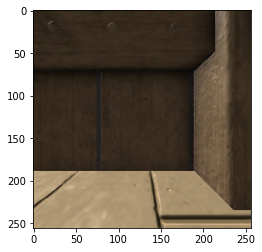

Step 154
Forward velocity 	 0.00
Right velocity 		 0.00
Up velocity 		 0.00
Cumulative reward -0.31


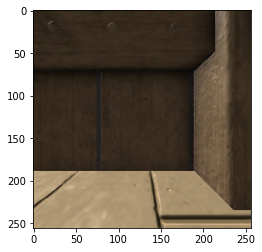

In [7]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import display, clear_output


fig, ax = plt.subplots()
vals  = ax.imshow(np.zeros((resolution, resolution,3)))
cumulative_reward = 0
# visual_observations[0].shape
for i in range(len(visual_observations)):
    
    vals.set_data(visual_observations[i].reshape((resolution, resolution,3)))
    
    clear_output(wait=True)
    display(fig)
    
    cumulative_reward+=rewards[i]
    print(f'Step {i}')
    print(f'Forward velocity \t {velocity_observations[i][0][2]:0.2f}')
    print(f'Right velocity \t\t {velocity_observations[i][0][0]:0.2f}')
    print(f'Up velocity \t\t {velocity_observations[i][0][1]:0.2f}')
    print(f'Cumulative reward {cumulative_reward:0.2f}')

In [8]:
if environment:
    environment.close() # takes a few seconds

That's pretty much it! In summary, we provide a very efficient environments manager (derived from ml-agents) which allows the training loop to be run over several instances of the environment, yielding improved performance. You can also use the Gym implementation of the environment - see the examples on training with OpenAI baselines for more information.

If you wish to train models using ml-agents, note that it is a very modular framework and that it may require some work to plug your own model in (depending on how far they are from PPO or SAC), but the performance gains are woth it! 

Well done! Now have a look at the **second notebook** on training an agent using animalai-train.